# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Optionally correct for the geoid (important in low-gradient / low-lying areas)
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
# def remove_duplicates(a):
#     """
#     find unique rows in numpy array 
#     <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
#     """
#     b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
#     dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
#     return dedup

# coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
# shapeRecs = coast_shape.shapeRecords()
# coords = []
# for record in shapeRecs:
#     coords.append(record.shape.points[:])
    
# coords = np.vstack(coords)

# # Remove duplicates
# points = remove_duplicates(coords)

In [3]:
## Define region of interest (here NZ)

bounds = (165.0, -48.5, 179.9, -34.0)
minX, minY, maxX, maxY = bounds

In [4]:
xres = 500
yres = 500

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T

In [5]:
gtiff = gdal.Open("../Notebooks/data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

In [6]:
# np.savez_compressed("ETOPO.npz", Description="Etopo1 Numpy Array 21600 x 10800", ETOPO1=img)



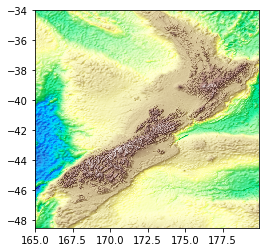

In [7]:
fig = plt.figure(1, figsize=(5,4))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
plt.show()

In [8]:
coords = np.stack((y1, x1)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [9]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest').astype(np.float)

# Fake geoid for this particular region
# meshheights -= 40.0 * (y1 - minY) / (maxY - minY)

In [10]:
## Filter out the points we don't want at all 

points = meshheights > -50 

m1s = meshheights[points]
x1s = x1[points]
y1s = y1[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


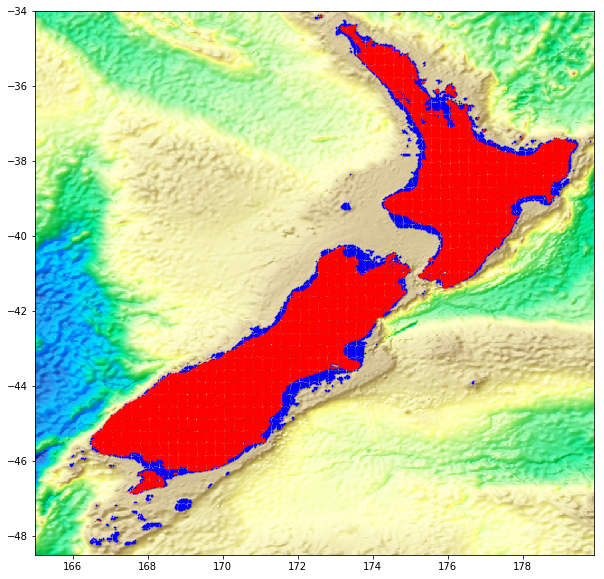

In [11]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[subaerial], y1s[subaerial], s=1.0, color="Red")

fig.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [12]:
DM = meshtools.create_DMPlex_from_points(x1s, y1s, submarine, refinement_steps=1)

In [13]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True)

0 - Delaunay triangulation 0.43211s
0 - Calculate node weights and area 0.007658s
0 - Find boundaries 0.010654s
0 - cKDTree 0.034739s
0 - Construct neighbour cloud array 0.990728s
0 - Construct rbf weights 0.197914s


In [14]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [15]:
## Now re-do the allocation of points to the surface.
## In parallel this will be done process by process for a sub-set of points

coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [16]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = mesh.rbf_smoother(meshheights, iterations=2)

raw_height = meshheights.copy() * 0.001

# meshheights -= 40.0 * (y2r - minY) / (maxY - minY)

In [17]:
subaerial =  meshheights >= -0.1
submarine = ~subaerial
mesh.bmask = subaerial

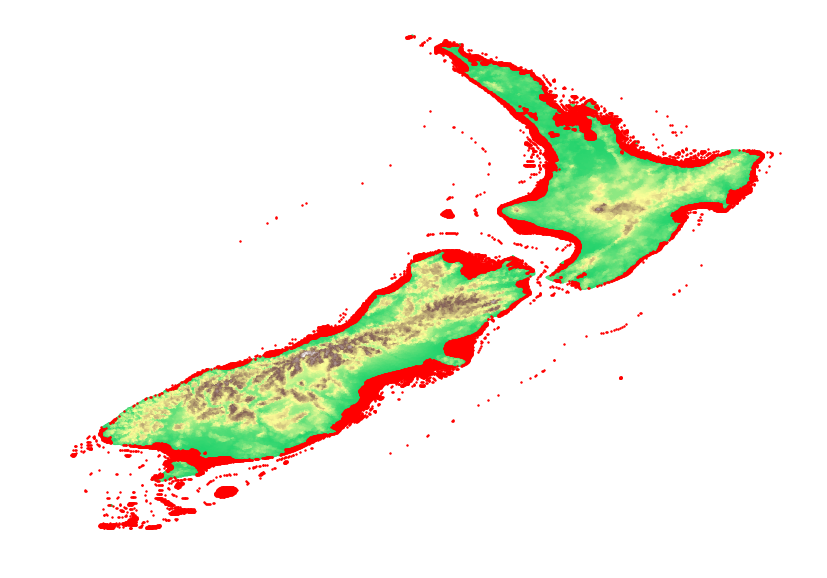

In [18]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[subaerial], y2r[subaerial], s=1.0, c=meshheights[subaerial], cmap=cm.terrain, vmin=-1000.0, vmax=2500)
sc = ax.scatter(x2r[submarine], y2r[submarine], s=2.0, c="Red", alpha=1.0)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
fig.show()

In [19]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))  

raw_heights = mesh.height.copy()

0 - Compute slopes 0.53795s
0 - Build downhill matrices 0.845351s
mean gradient 3.89312291145
number of flat spots 2057
number of low points 667


In [21]:
its, flowpaths1 = mesh.cumulative_flow_verbose(mesh.area, verbose=True)
flowpaths1 = mesh.rbf_smoother(flowpaths1)

0: Max Delta - 3.46115528598 
10: Max Delta - 0.0727041418449 
20: Max Delta - 0.0014036851287 
30: Max Delta - 0.00150646915109 
40: Max Delta - 0.000642352964791 
50: Max Delta - 0.000392528510457 
60: Max Delta - 0.0004296064982 
70: Max Delta - 0.000424252755856 
80: Max Delta - 0.000126850867683 
90: Max Delta - 4.59519583985e-08 


In [22]:
new_heights=mesh.low_points_local_patch_fill(its=2)
mesh._update_height_partial(new_heights)
low_points2 = mesh.identify_low_points()
print low_points2.shape

Low point local patch fill
 - Partial rebuild of downhill matrices 0.705519s
 - Partial rebuild of downhill matrices 0.694846s
Low point local patch fill  1.560823  seconds
 - Partial rebuild of downhill matrices 0.685917s
(446,)


In [23]:
new_heights = mesh.low_points_swamp_fill(ref_height=-0.01)

print new_heights.min()

86  iterations, time =  1.182499
Build low point catchments -  1.183502  seconds
0  Sort spills -  0.027128
0  Gather spill data -  0.001471
0  Sort all spills -  0.000896999999998
 - Partial rebuild of downhill matrices 0.628817s
Low point swamp fill  2.054038  seconds
-0.01


In [24]:
for i in range(0,10):
    new_heights = mesh.low_points_swamp_fill(ref_height=-0.01)
    mesh._update_height_partial(new_heights)
    # mesh.update_height(new_heights)
    low_points2 = mesh.identify_low_points()
    print low_points2.shape

112  iterations, time =  1.406768
Build low point catchments -  1.407852  seconds
0  Sort spills -  0.022905
0  Gather spill data -  0.000167000000001
0  Sort all spills -  9.59999999992e-05
 - Partial rebuild of downhill matrices 0.656182s
Low point swamp fill  2.199496  seconds
 - Partial rebuild of downhill matrices 0.631843s
(20,)
160  iterations, time =  1.987192
Build low point catchments -  1.988343  seconds
0  Sort spills -  0.027508
0  Gather spill data -  0.000167000000001
0  Sort all spills -  0.000101000000001
 - Partial rebuild of downhill matrices 0.575434s
Low point swamp fill  2.689966  seconds
 - Partial rebuild of downhill matrices 0.592506s
(9,)
186  iterations, time =  2.329151
Build low point catchments -  2.330032  seconds
0  Sort spills -  0.023963
0  Gather spill data -  0.000138
0  Sort all spills -  7.39999999979e-05
 - Partial rebuild of downhill matrices 0.621412s
Low point swamp fill  3.068033  seconds
 - Partial rebuild of downhill matrices 0.63143s
(6,)
1

In [70]:
mesh.update_height(new_heights)
lakes = mesh.height - raw_heights
# lakes[~mesh.bmask] = 0.0

print lakes.max(), mesh.height.max(), mesh.height.min()

0 - Compute slopes 0.424673s
0 - Build downhill matrices 0.787025s
2.87178500578 2.56994398097 -0.01


In [73]:
mesh.height.min()

-0.01

In [74]:
its, flowpaths = mesh.cumulative_flow_verbose(np.ones_like(mesh.height), verbose=True)
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

0: Max Delta - 5.03850946295 
10: Max Delta - 5.60417338538 
20: Max Delta - 9.52200022258 
30: Max Delta - 7.34551768957 
40: Max Delta - 5.21704447099 
50: Max Delta - 5.11025372427 
60: Max Delta - 5.10795192807 
70: Max Delta - 6.59652124827 
80: Max Delta - 5.80645523436 
90: Max Delta - 4.84286826069 
100: Max Delta - 3.93279966124 
110: Max Delta - 3.90262177079 
120: Max Delta - 4.74549936327 
130: Max Delta - 3.58761682528 
140: Max Delta - 3.4855206959 
150: Max Delta - 3.34516138895 
160: Max Delta - 3.15310554916 
170: Max Delta - 3.22481626743 
180: Max Delta - 1.43465547261 
190: Max Delta - 0.406449887482 
200: Max Delta - 0.0145550721265 
210: Max Delta - 7.13164336302e-05 
220: Max Delta - 3.44888087835e-09 


In [75]:
minx = mesh.tri.x.min()
miny = mesh.tri.y.min()
maxx = mesh.tri.x.max()
maxy = mesh.tri.y.max()
refheight = 0.01

bplanexy = np.array([ (minx, miny, refheight), 
                      (minx, maxy, refheight), 
                      (maxx, maxy, refheight), 
                      (maxx, miny, refheight)])

bplane_tri = [ (0, 1, 2), (0, 2, 3)]


In [76]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

bplane = lv.triangles('bplane', wireframe=False, colour=(0.5,0.7,0.9,1.0))
bplane.vertices(bplanexy)
bplane.indices(bplane_tri)

lv.window()

<IPython.core.display.Javascript object>

In [85]:
manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=raw_heights*0.25, axis=1)

from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)


topo  = lv.triangles("topography",  wireframe=False)
topo.vertices(manifold)
topo.indices(mesh.tri.simplices)
topo.values(raw_heights, 'topography')
topo["zmin"] = -0.05

topo.colourmap(["(-1.0)#FFFFFF:0.0", "(0.0)#FFFFFF:0.0","(0.01)#FFFF99:1.0", "(0.5)#33AA11:1.0", "(2.5)#886644:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap


topo2  = lv.triangles("topography2",  wireframe=False)
topo2.vertices(manifold)
topo2.indices(mesh.tri.simplices)
topo2.values(mesh.height, 'topography')
topo2["zmin"] = -0.05

topo2.colourmap(["(-1.0)#FFFFFF:0.0", "(0.0)#FFFFFF:0.0","(0.01)#FFFF99:1.0", "(0.5)#33AA11:1.0", "(2.5)#886644:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap



flowpath2 = lv.triangles("flow2",  wireframe=False)
flowpath2.vertices(manifold+(0.0,0.0,0.02))
flowpath2.indices(mesh.tri.simplices)
flowpath2.values(flowpaths2, 'flow2')
flowpath2["zmin"] = -0.05
flowpath2.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=True)   # Apply a built in colourmap

## LAKES / SWAMPS


lakeheight = lakes.copy()
lakeheight[lakes > 0.0] += raw_heights[lakes > 0.0]
lakeheight[lakes <= 0.0] = 0.0 # raw_heights[lakes <= 0.0] - 0.1

manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=lakeheight*0.25, axis=1)

# lakeheight[lakes <= 0.0] = 0.0



lakeview = lv.triangles("lakes",  wireframe=False, colour="#00FFEE:0.5")
lakeview.vertices(manifold+(0.0,0.0,0.02))
lakeview.indices(mesh.tri.simplices)
lakeview.values(lakeheight, 'flow2')
lakeview["zmin"] = -0.05

lakeview.colourmap(["(-1.0)#FFFFFF:0.0","(0.0)#FFFFFF:0.0", "(0.05)#55FFEE:1.0", "(1.0)#00FFEE:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap


# topo2  = lv.triangles("topography2",  wireframe=False)
# topo2.vertices(manifold2)
# topo2.indices(meshTri.tri.simplices)
# topo2.values(h2vec.array, 'topography2')
# topo2["zmin"] = -.05


# flowverlay = lv.triangles("flow_surface", wireframe=False)
# flowverlay.vertices(manifold + (0.0,0.0, 5.0))
# flowverlay.indices(mesh.tri.simplices)
# flowverlay.values(np.sqrt(flowpaths), 'flowpaths')


# cb = topo.colourbar("topocolourbar", visible=False) # Add a colour bar
# cb2 = flowverlay.colourbar("flowcolourbar", visible=False) # Add a colour bar



# cm2 = topo2.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.0, 1.0])   # Apply a built in colourmap


#Filter by min height value

# lows = lv.points(pointsize=5.0, pointtype="shiny", opacity=0.75)
# lows.vertices(low_cloud+(0.0,0.0,20.0))
# lows.values(flowpaths[low_points])
# lows.colourmap(lavavu.cubeHelix()) #, range=[0,0.1])
# lows.colourbar(visible=True)


bplane = lv.triangles('bplane', wireframe=False, colour=(0.5,0.7,0.9,1.0))
bplane.vertices(bplanexy)
bplane.indices(bplane_tri)



In [86]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
99 = 1

SyntaxError: can't assign to literal (<ipython-input-32-1eafd4f891c0>, line 1)

In [ ]:
manifold = np.reshape(mesh.coords[mesh.bmask], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[mesh.bmask]*0.25, axis=1)

In [ ]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow')


# topo3 = lv.points(pointsize=2.0, pointtype=0)
# topo3.vertices(manifold+(0.0,0.0,0.1))
# # topo.values(mesh.height, label='height')
# topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

# topo3.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap



In [ ]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [ ]:
filename = 'NZTopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, 
                                  height0=raw_heights,
                                  slope=mesh.slope, 
                                  flow1=np.sqrt(flowpaths1),
                                  flow2=np.sqrt(flowpaths2),
                                  lakes = lakes)

# to view in Paraview
meshtools.generate_xdmf(filename)